In [1]:
import numpy as np
from cmdstanpy import cmdstan_path, CmdStanModel, set_cmdstan_path

import matplotlib.pyplot as plt
import arviz as az
import os
import tqdm

import sys
sys.path.append('../scripts')
    
from parameter_estimation import BivariateBeta

## Stan Model

For using the following notebook, it is necessary to set the `cmdstan` path correctly. 

In [2]:
set_cmdstan_path('/home/lucasmoschen/anaconda3/envs/project-beta/bin/cmdstan')

Then, we can proceed the compilation.

In [3]:
stanfile1 = os.path.join('..', 'scripts', 'bivariate-beta-model.stan')
model_v1 = CmdStanModel(stan_file=stanfile1, cpp_options={'STAN_THREADS':'true'})

stanfile2 = os.path.join('..', 'scripts', 'bivariate-beta-model-v2.stan')
model_v2 = CmdStanModel(stan_file=stanfile2, cpp_options={'STAN_THREADS':'true'})

stanfile3 = os.path.join('..', 'scripts', 'bivariate-beta-model-v3.stan')
model_v3 = CmdStanModel(stan_file=stanfile3, cpp_options={'STAN_THREADS':'true'})

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiling stan file /home/lucasmoschen/Documents/GitHub/bivariate-beta/scripts/bivariate-beta-model-v3.stan to exe file /home/lucasmoschen/Documents/GitHub/bivariate-beta/scripts/bivariate-beta-model-v3
INFO:cmdstanpy:compiled model executable: /home/lucasmoschen/Documents/GitHub/bivariate-beta/scripts/bivariate-beta-model-v3


## Quick verifications

Generating the data

In [25]:
true_alpha = np.array([2,7,3,1])
n = 50
U = np.random.dirichlet(true_alpha, size=n)
X = U[:,0] + U[:,1]
Y = U[:,0] + U[:,2]
XY = np.column_stack([X,Y])

# Gamma hyperparameters
a = np.array([1,1,1,1])
b = 0.1*np.array([1,1,1,1])

# bojum prior
m = -0.9
r = b

# uniform-exponential prior
p = 0.5*np.ones(4)
lambd = np.ones(4)
c = 100*np.ones(4)

data = {'n': n, 'xy': XY, 
        'prior_alpha': 1, 'a': a, 'b': b, 'm': m, 'r': r, 'p': p, 'lambda': lambd, 'c': c, 
        'tolerance': 1e-8}

## Model V1

In [26]:
model_fit_v1 = model_v1.sample(data=data, chains=4, iter_sampling=1000)

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [27]:
print(model_fit_v1.diagnose())

Processing csv files: /tmp/tmpokt8whhh/bivariate-beta-model-20220617010052_1.csv, /tmp/tmpokt8whhh/bivariate-beta-model-20220617010052_2.csv, /tmp/tmpokt8whhh/bivariate-beta-model-20220617010052_3.csv, /tmp/tmpokt8whhh/bivariate-beta-model-20220617010052_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



In [28]:
df = model_fit_v1.summary()
df[df.index.str.contains('alpha')]

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
alpha[1],1.90,0.0120,0.42,1.30,1.90,2.7,1187.0,1.2,1.0
alpha[2],6.90,0.0260,1.00,5.20,6.80,8.7,1581.0,1.6,1.0
alpha[3],2.80,0.0110,0.46,2.00,2.80,3.6,1668.0,1.7,1.0
alpha[4],0.91,0.0092,0.33,0.46,0.87,1.5,1256.0,1.3,1.0


In [29]:
inf_data = az.from_cmdstanpy(model_fit_v1)

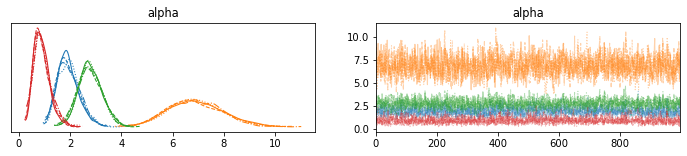

In [30]:
az.plot_trace(inf_data)
plt.show()

## Model V2

In [31]:
model_fit_v2 = model_v2.sample(data=data, chains=4, iter_sampling=1000)

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [32]:
print(model_fit_v2.diagnose())

Processing csv files: /tmp/tmpokt8whhh/bivariate-beta-model-v2-20220617010918_1.csv, /tmp/tmpokt8whhh/bivariate-beta-model-v2-20220617010918_2.csv, /tmp/tmpokt8whhh/bivariate-beta-model-v2-20220617010918_3.csv, /tmp/tmpokt8whhh/bivariate-beta-model-v2-20220617010918_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



In [33]:
df = model_fit_v2.summary()
df[df.index.str.contains('alpha')]

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
alpha[1],1.90,0.0230,0.43,1.30,1.90,2.7,352.0,92.0,1.0
alpha[2],6.90,0.0290,1.00,5.30,6.80,8.7,1340.0,349.0,1.0
alpha[3],2.80,0.0096,0.44,2.10,2.80,3.6,2138.0,557.0,1.0
alpha[4],0.89,0.0190,0.32,0.45,0.84,1.5,285.0,74.0,1.0


## Model V3 

Let it to be faster! I couldn't yet, unhappily...

In [34]:
model_fit_v3 = model_v3.sample(data=data, chains=4, iter_sampling=1000, iter_warmup=1000, adapt_delta=0.8)

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [35]:
print(model_fit_v3.diagnose())

Processing csv files: /tmp/tmpokt8whhh/bivariate-beta-model-v3-20220617010922_1.csv, /tmp/tmpokt8whhh/bivariate-beta-model-v3-20220617010922_2.csv, /tmp/tmpokt8whhh/bivariate-beta-model-v3-20220617010922_3.csv, /tmp/tmpokt8whhh/bivariate-beta-model-v3-20220617010922_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



In [36]:
df = model_fit_v3.summary()
df[df.index.str.contains('alpha')]

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
alpha[1],1.90,0.021,0.40,1.30,1.90,2.6,372.0,133.0,1.0
alpha[2],6.90,0.027,1.00,5.30,6.80,8.6,1468.0,524.0,1.0
alpha[3],2.80,0.010,0.45,2.10,2.80,3.6,1878.0,670.0,1.0
alpha[4],0.88,0.018,0.31,0.45,0.84,1.4,292.0,104.0,1.0


## Comparing v1 and v2

They should provide similar estimates for the same data.

In [38]:
comparing = ['Mean', '5%', '50%', '95%']
diff = abs(model_fit_v1.summary()[comparing].iloc[1:5] - model_fit_v2.summary()[comparing].iloc[1:5])
diff = diff/model_fit_v1.summary()[comparing].iloc[1:5]
# the percentage error is
diff

,Mean,5%,50%,95%
name,,,,
alpha[1],0.000000,0.000000,0.000000,0.0
alpha[2],0.000000,0.019231,0.000000,0.0
alpha[3],0.000000,0.050000,0.000000,0.0
alpha[4],0.021978,0.021739,0.034483,0.0


## Simulated-based calibration

https://arxiv.org/pdf/1804.06788.pdf

https://betanalpha.github.io/assets/case_studies/principled_bayesian_workflow.html

Consider the prior $\alpha \sim \operatorname{Gamma}(a=2, b=0.1)$

In [121]:
a, b = 2, 0.1

# Gamma hyperparameters
a = a*np.ones(4)
b = b*np.ones(4)

# bojum prior
m = -0.9
r = b

# uniform-exponential prior
p = 0.5*np.ones(4)
lambd = np.ones(4)
c = 100*np.ones(4)

n = 50

data = {'n': n,
        'prior_alpha': 1, 'a': a, 'b': b, 'm': m, 'r': r, 'p': p, 'lambda': lambd, 'c': c, 
        'tolerance': 1e-8}

R = 10

In [154]:
rho_values = []
for i in range(200):
    true_alpha = np.random.gamma(shape=a, scale=1/b, size=4)
    U = np.random.dirichlet(true_alpha, size=(n,))
    XY = np.column_stack([U[:,0] + U[:,1], U[:,0] + U[:,2]])
    data['xy'] = XY
    model_fit = model_v3.sample(data=data, iter_warmup=1000, show_progress=False, show_console=False, iter_sampling=1000, chains=1)
    alpha1 = np.random.choice(model_fit.stan_variables()['alpha'][:,0], size=R, replace=False)
    rho = np.sum(alpha1 > true_alpha[0])
    rho_values.append(rho)

INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:C

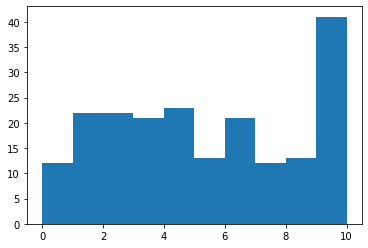

In [155]:
plt.hist(rho_values)
plt.show()

In [132]:
samples = np.zeros((200,4))
prior = np.zeros((200,4))
for i in tqdm.tqdm(range(200), position=0):    
    true_alpha = np.random.gamma(shape=a, scale=1/b, size=4)
    U = np.random.dirichlet(true_alpha, size=(n,))
    XY = np.column_stack([U[:,0] + U[:,1], U[:,0] + U[:,2]])
    data['xy'] = XY
    model_fit = model_v3.sample(data=data, iter_warmup=1000, show_progress=False, show_console=False, iter_sampling=1000, chains=1)
    alpha_hat = model_fit.stan_variables()['alpha'][-1,:]
    samples[i] = alpha_hat
    prior[i] = true_alpha

  0%|                                                   | 0/200 [00:00<?, ?it/s]INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
  0%|▏                                          | 1/200 [00:00<03:17,  1.01it/s]INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
  1%|▍                                          | 2/200 [00:01<03:15,  1.01it/s]INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
  2%|▋                                          | 3/200 [00:02<03:10,  1.03it/s]INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
  2%|▊                                          | 4/200 [00:03<02:52,  1.14it/s]INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] d

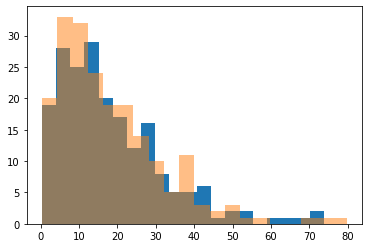

In [145]:
plt.hist(prior[:,0], bins=20)
plt.hist(samples[:,0], bins=20, alpha=0.5)
plt.show()

## Prior analysis model v2

In [177]:
data['prior_alpha'] = 1
model_fit1 = model_v2.sample(data=data, chains=4, iter_sampling=1000, show_progress=False)
data['prior_alpha'] = 2
model_fit2 = model_v2.sample(data=data, chains=4, iter_sampling=1000, show_progress=False)
data['prior_alpha'] = 3
model_fit3 = model_v2.sample(data=data, chains=4, iter_sampling=1000, show_progress=False)
data['prior_alpha'] = 4
model_fit4 = model_v2.sample(data=data, chains=4, iter_sampling=1000, show_progress=False)
data['prior_alpha'] = 5
model_fit5 = model_v2.sample(data=data, chains=4, iter_sampling=1000, show_progress=False)

INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan done processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan done processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan done processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan done processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan done processing


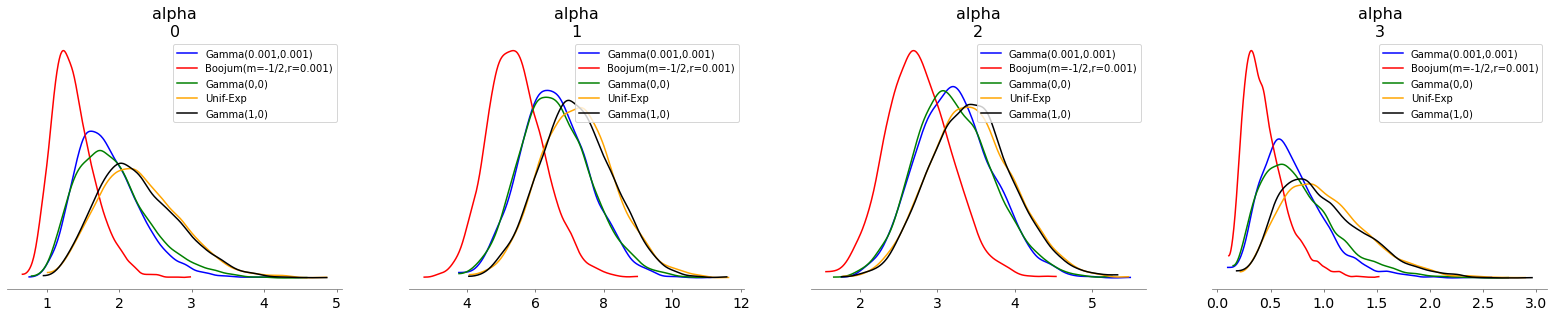

In [178]:
ax = az.plot_posterior(model_fit1, var_names=['alpha'], hdi_prob='hide', point_estimate=None, color='blue', label='Gamma(0.001,0.001)')
az.plot_posterior(model_fit2, var_names=['alpha'], ax=ax, hdi_prob='hide', point_estimate=None, color='red', label='Boojum(m=-1/2,r=0.001)')
az.plot_posterior(model_fit3, var_names=['alpha'], ax=ax, hdi_prob='hide', point_estimate=None, color='green', label='Gamma(0,0)')
az.plot_posterior(model_fit4, var_names=['alpha'], ax=ax, hdi_prob='hide', point_estimate=None, color='orange', label='Unif-Exp')
az.plot_posterior(model_fit5, var_names=['alpha'], ax=ax, hdi_prob='hide', point_estimate=None, color='black', label='Gamma(1,0)')
plt.show()

## Marginal gain of increasing sampling

In [225]:
true_alpha = np.array([2,7,3,1])

# Gamma hyperparameters
a = 0.001*np.array([1,1,1,1])
b = 0.001*np.array([1,1,1,1])

n = 50
U = np.random.dirichlet(true_alpha, size=n)
X = U[:,0] + U[:,1]
Y = U[:,0] + U[:,2]
XY = np.column_stack([X,Y])

data = {'n': n, 'xy': XY, 
        'prior_alpha': 1, 'a': a, 'b': b, 'm': m, 'r': r, 'p': p, 'lambda': lambd, 'c': c, 
        'tolerance': 1e-8}

In [247]:
n_values = [10, 30, 50, 100, 200, 500, 1000]
alpha_samples = np.zeros((len(n_values),4000,4))

for i, n in enumerate(n_values):
    
    U = np.random.dirichlet(true_alpha, size=n)
    X = U[:,0] + U[:,1]
    Y = U[:,0] + U[:,2]
    XY = np.column_stack([X,Y])
    
    data['n'] = n
    data['xy'] = XY
    model_fit = model_v2.sample(data=data, chains=4, iter_sampling=1000, show_progress=False, show_console=False)
    
    alpha_samples[i,:,:] = model_fit.stan_variable('alpha')

INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan done processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan done processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan done processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan done processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan done processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan done processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan done processing


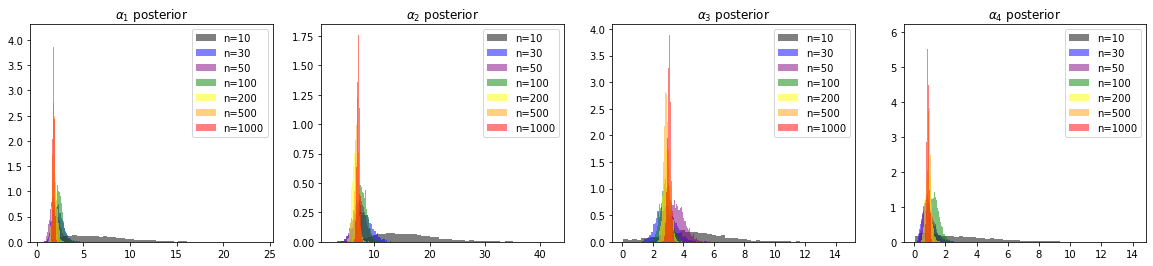

In [250]:
fig, ax = plt.subplots(1, 4, figsize=(20,4))
colors = ['black', 'blue', 'purple', 'green', 'yellow', 'orange', 'red']
for i in range(4):
    for k in range(7):
        ax[i].hist(alpha_samples[k,:,i], bins=50, color=colors[k], alpha=0.5, label='n={}'.format(n_values[k]), density=True)
    ax[i].set_title(r'$\alpha_{}$ posterior'.format(i+1))
    ax[i].legend()
plt.show()

## Analyzing the estimation

In [185]:
true_alpha = np.array([1,1,1,1])
n = 50
monte_carlo_simulation = 1000
U = np.random.dirichlet(true_alpha, size=(n, monte_carlo_simulation))
X = U[:,:,0] + U[:,:,1]
Y = U[:,:,0] + U[:,:,2]

In [186]:
# Gamma hyperparameters
a = 0.001*np.array([1,1,1,1])
b = 0.001*np.array([1,1,1,1])

# bojum prior
m = -0.9
r = b

# uniform-exponential prior
p = 0.5*np.ones(4)
lambd = np.ones(4)
c = 100*np.ones(4)

data = {'n': n, 'xy': XY, 
        'prior_alpha': 1, 'a': a, 'b': b, 'm': m, 'r': r, 'p': p, 'lambda': lambd, 'c': c, 
        'tolerance': 1e-8}

In [187]:
mse = np.zeros(4)
bias = np.zeros(4)
coverage = np.zeros(4)
mape = np.zeros(4)

for i in tqdm.tqdm(range(monte_carlo_simulation)):
    XY = np.column_stack([X[:,i],Y[:,i]])
    data['xy'] = XY
    model_fit_v2 = model_v2.sample(data=data, chains=4, iter_sampling=1000, show_progress=False, show_console=False)
    df = model_fit_v2.summary(percentiles=(2.5, 97.5))
    
    alpha_hat = df.iloc[1:5].Mean.values
    lb = df.iloc[1:5]['2.5%'].values
    ub = df.iloc[1:5]['97.5%'].values
    
    bias_new = alpha_hat - true_alpha
    mse_new = bias_new * bias_new
    mape_new = abs(bias_new)/true_alpha
    coverage_new = (lb < true_alpha)*(ub > true_alpha)
    
    bias = (bias * i + bias_new)/(i+1)
    mse = (mse * i + mse_new)/(i+1)
    mape = (mape * i + mape_new)/(i+1)
    coverage = (coverage * i + coverage_new)/(i+1)

  0%|                                                  | 0/1000 [00:00<?, ?it/s]INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan done processing
  0%|                                        | 1/1000 [00:04<1:14:14,  4.46s/it]INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan done processing
  0%|                                        | 2/1000 [00:09<1:17:58,  4.69s/it]INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan done processing
  0%|                                        | 3/1000 [00:14<1:17:57,  4.69s/it]INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan done processing
  0%|▏                                       | 4/1000 [00:18<1:16:57,  4.64s/it]INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan done processing
  0%|

In [188]:
true_alpha = np.array([1,1,1,1])
n = 1000
monte_carlo_simulation = 1000
U = np.random.dirichlet(true_alpha, size=(n, monte_carlo_simulation))
X = U[:,:,0] + U[:,:,1]
Y = U[:,:,0] + U[:,:,2]

In [189]:
data = {'n': n, 'xy': XY, 
        'prior_alpha': 1, 'a': a, 'b': b, 'm': m, 'r': r, 'p': p, 'lambda': lambd, 'c': c, 
        'tolerance': 1e-8}

In [194]:
coverage

array([0.936, 0.931, 0.94 , 0.935])

In [ ]:
mse2 = np.zeros(4)
bias2 = np.zeros(4)
coverage2 = np.zeros(4)
mape2 = np.zeros(4)

for i in tqdm.tqdm(range(monte_carlo_simulation)):
    XY = np.column_stack([X[:,i],Y[:,i]])
    data['xy'] = XY
    model_fit_v2 = model_v2.sample(data=data, chains=4, iter_sampling=1000, show_progress=False, show_console=False)
    df = model_fit_v2.summary(percentiles=(2.5, 97.5))
    
    alpha_hat = df.iloc[1:5].Mean.values
    lb = df.iloc[1:5]['2.5%'].values
    ub = df.iloc[1:5]['97.5%'].values
    
    bias_new = alpha_hat - true_alpha
    mse_new = bias_new * bias_new
    mape_new = abs(bias_new)/true_alpha
    coverage_new = (lb < true_alpha)*(ub > true_alpha)
    
    bias2 = (bias2 * i + bias_new)/(i+1)
    mse2 = (mse2 * i + mse_new)/(i+1)
    mape2 = (mape2 * i + mape_new)/(i+1)
    coverage2 = (coverage2 * i + coverage_new)/(i+1)

## Jeffreys' prior

Calculating Jeffreys prior for $p(\alpha, u)$.

In [64]:
import sympy as sp

In [86]:
alpha1, alpha2, alpha3, alpha4, u, x, y = sp.symbols('alpha_1 alpha_2 alpha_3 alpha4 u x y')

f = (x-u)**(alpha2-1) * (y-u)**(alpha3-1) * (1-x-y+u)**(alpha4-1) / (1-u)**(alpha2+alpha3+alpha4-1)
f /= sp.gamma(alpha2)*sp.gamma(alpha3)*sp.gamma(alpha4)/sp.gamma(alpha2+alpha3+alpha4)
l = sp.expand_log(sp.log(f), force=True)

In [87]:
l_2 = sp.diff(l, alpha2)
l_3 = sp.diff(l, alpha3)
l_4 = sp.diff(l, alpha4)
l_u = sp.diff(l, u)

M = sp.Matrix([[l_2.diff(alpha2), l_2.diff(alpha3), l_2.diff(alpha4), l_2.diff(u)],
               [l_3.diff(alpha2), l_3.diff(alpha3), l_3.diff(alpha4), l_3.diff(u)],
               [l_4.diff(alpha2), l_4.diff(alpha3), l_4.diff(alpha4), l_4.diff(u)],
               [l_u.diff(alpha2), l_u.diff(alpha3), l_u.diff(alpha4), l_u.diff(u)]])

M

Matrix([
[-polygamma(1, alpha_2) + polygamma(1, alpha4 + alpha_2 + alpha_3),                          polygamma(1, alpha4 + alpha_2 + alpha_3),                         polygamma(1, alpha4 + alpha_2 + alpha_3),                                                                                                                 -1/(-u + x) + 1/(1 - u)],
[                         polygamma(1, alpha4 + alpha_2 + alpha_3), -polygamma(1, alpha_3) + polygamma(1, alpha4 + alpha_2 + alpha_3),                         polygamma(1, alpha4 + alpha_2 + alpha_3),                                                                                                                 -1/(-u + y) + 1/(1 - u)],
[                         polygamma(1, alpha4 + alpha_2 + alpha_3),                          polygamma(1, alpha4 + alpha_2 + alpha_3), -polygamma(1, alpha4) + polygamma(1, alpha4 + alpha_2 + alpha_3),                                                                                                           1/(u -

$x-u = u_2 \sim Beta(\alpha_2, \alpha_1+\alpha_3+\alpha_4)$

$y-u = u_3 \sim Beta(\alpha_3, \alpha_1+\alpha_2+\alpha_4)$

$1-x-y+u = u_4 \sim Beta(\alpha_4, \alpha_1+\alpha_2+\alpha_3)$

I notice that if $X \sim Beta(\alpha, \beta)$, then $E[X^{-n}] = B(\alpha-n, \beta)/Beta(\alpha, \beta)$ if $\alpha > n$ and infinity otherwise.

In [99]:
M[3,3] = M[3,3].subs(1/(x-u)**2, sp.beta(alpha2-2, alpha1+alpha3+alpha4)/sp.beta(alpha2, alpha1+alpha3+alpha4))
M[3,3] = M[3,3].subs(1/(y-u)**2, sp.beta(alpha3-2, alpha1+alpha2+alpha4)/sp.beta(alpha3, alpha1+alpha2+alpha4))
v = M[3,3].subs(1/(1-x-y+u)**2, sp.beta(alpha4-2, alpha1+alpha2+alpha3)/sp.beta(alpha4, alpha1+alpha2+alpha3))
M = M.subs(1/(x-u), sp.beta(alpha2-1, alpha1+alpha3+alpha4)/sp.beta(alpha2, alpha1+alpha3+alpha4))
M = M.subs(1/(y-u), sp.beta(alpha3-1, alpha1+alpha2+alpha4)/sp.beta(alpha3, alpha1+alpha2+alpha4))
M = M.subs(1/(1-x-y+u), sp.beta(alpha4-1, alpha1+alpha2+alpha3)/sp.beta(alpha4, alpha1+alpha2+alpha3))
M[3,3] = v
M

Matrix([
[                                   -polygamma(1, alpha_2) + polygamma(1, alpha4 + alpha_2 + alpha_3),                                                             polygamma(1, alpha4 + alpha_2 + alpha_3),                                                            polygamma(1, alpha4 + alpha_2 + alpha_3),                                                                                                                                                                                                                                                                 -beta(alpha_2 - 1, alpha4 + alpha_1 + alpha_3)/beta(alpha_2, alpha4 + alpha_1 + alpha_3) + 1/(1 - u)],
[                                                            polygamma(1, alpha4 + alpha_2 + alpha_3),                                    -polygamma(1, alpha_3) + polygamma(1, alpha4 + alpha_2 + alpha_3),                                                            polygamma(1, alpha4 + alpha_2 + alpha_3),                     

Note que a priori de Jeffreys só está definida se $\alpha_i > 2, i=2,3,4$, isto é, a densidade tem valor inifinito se $\alpha_2 \le 2$, por exemplo.